In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-13 09:23:09.332193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 09:23:09.939823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
# Load h5ad object
adata = anndata.read_h5ad("data/fede_count.h5ad")
# Map appropriate condition tags
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

# Load cell annotation info
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]

In [4]:
# Initial QC and filtering
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
# Calculate mitochondrial genes percentage
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

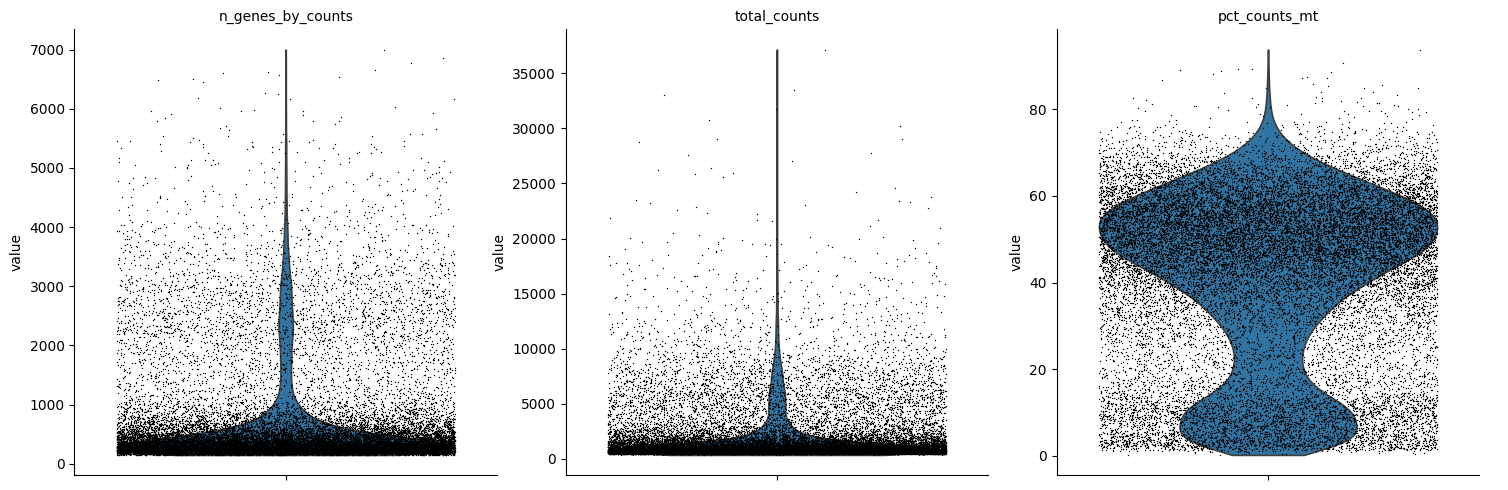

In [7]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

In [9]:
# Filter cells
adata = adata[(adata.obs.pct_counts_mt < 50), :]

In [11]:
# Filter multiplets if applicable (assuming Sample_Name is a column in adata.obs)
adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]

In [13]:
# Saving raw counts before data transformation
adata.raw = adata

In [14]:
# Normalization and identifying variable genes
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True, max_fraction=0.05)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)

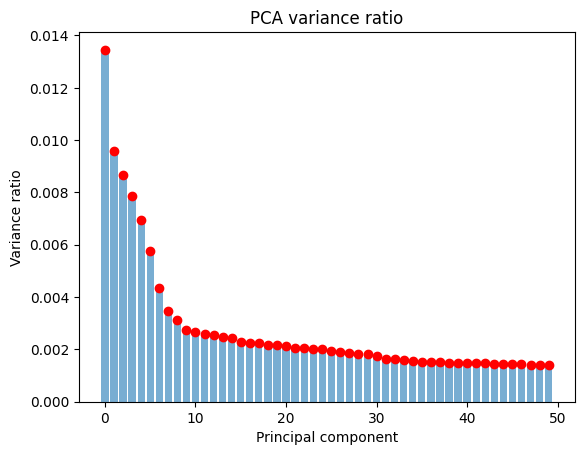

In [15]:
# Plot explained variance vs PCs
elbow_plot(adata)

In [ ]:
# Dimension heatmap
dimension_heatmap(adata, n_components=15, n_cells=500)

In [16]:
# PCA with optimal n_comps
sc.tl.pca(adata, n_comps=10)

# Harmony batch correction
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

# Neighbors and clustering using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=10)
sc.tl.leiden(adata, resolution=0.5)

# UMAP and t-SNE
sc.tl.umap(adata)
sc.tl.tsne(adata)

2024-06-13 09:36:10,882 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-13 09:36:11,888 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-13 09:36:11,924 - harmonypy - INFO - Iteration 1 of 10
2024-06-13 09:36:13,907 - harmonypy - INFO - Iteration 2 of 10
2024-06-13 09:36:15,985 - harmonypy - INFO - Converged after 2 iterations
/tmp/ipykernel_14041/3555927198.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


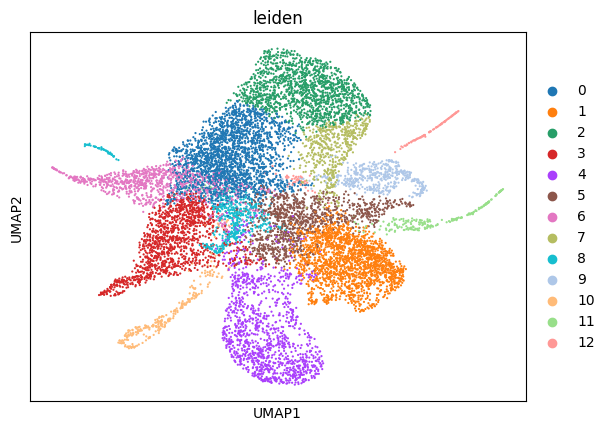

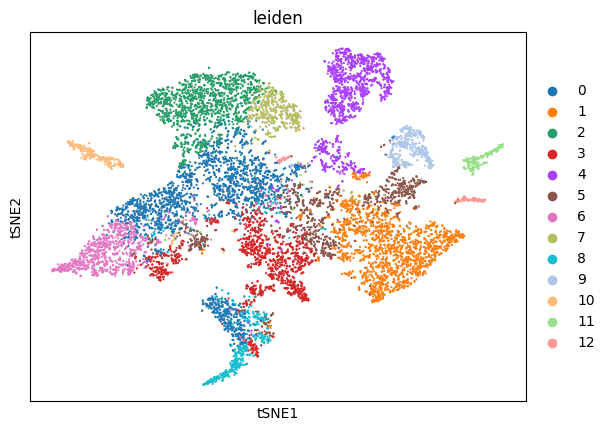

In [17]:
# Plotting
sc.pl.umap(adata, color=['leiden'], save='umap.png')
sc.pl.tsne(adata, color=['leiden'], save='tsne.png')

In [18]:
adata.obs['cell_id'] = adata.obs.index.astype(str)
anno_df.index = anno_df.index.astype(str)
adata.obs = adata.obs.merge(anno_df, left_on='cell_id', right_index=True, how='left')
# Assign unique cell type names to each cluster
assign_unique_cell_type_names(adata)
# Ensure leiden and annotated_cluster are strings for concatenation
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['annotated_cluster'] = adata.obs['annotated_cluster'].astype(str)

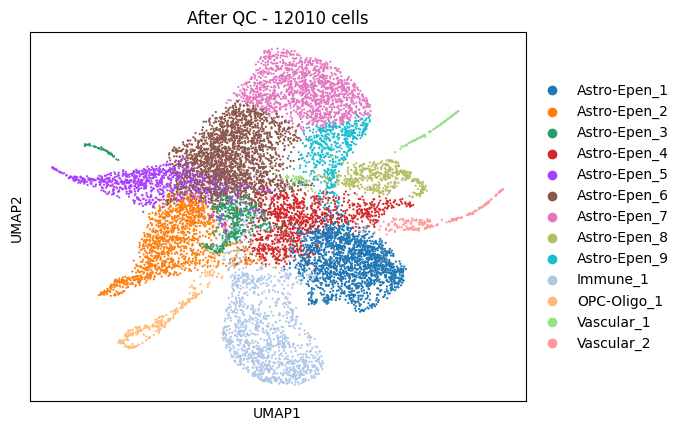

In [19]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata, color=['annotated_cluster'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

In [ ]:
sample_tags = adata.obs['Sample_Tag'].unique()
plot_umap(adata, sample_tags, legend_fontsize=5)

In [ ]:
sample_tag_counts = get_master_table(adata)

In [ ]:
get_ditto(sample_tag_counts)

In [ ]:
#ctr, cnd = 'WT-DMSO', '3xTg-DMSO'
ctr, cnd = 'WT-SCDi', '3xTg-SCDi'

In [ ]:
cell_types = [x for x in set(adata.obs.annotated_cluster.values)]

In [ ]:
cluster_n_DEGs = []
min_fold_change = 0.25
max_p_value = 0.05
for cell_type in tqdm(cell_types):
    df = DEG_analysis(adata, ctr, cnd, [cell_type])
    positive_enriched = df[(df['logfoldchanges'] > min_fold_change) & (df['pvals_adj'] < max_p_value)]
    negative_enriched = df[(df['logfoldchanges'] < -min_fold_change) & (df['pvals_adj'] < max_p_value)]
    positive_count = positive_enriched.shape[0]
    negative_count = negative_enriched.shape[0]
    cluster_n_DEGs.append((cell_type, positive_count, negative_count))

In [ ]:
horizontal_deg_chart(cluster_n_DEGs, 'wt_scdi_vs_tg_scdi')

In [ ]:
results_df = DEG_analysis(adata, ctr, cnd, ['Astro-Epen_6'])

In [ ]:
get_volcano_plot(results_df, 'wt_scdi_vs_tg_scdi')